In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 200)

import warnings
warnings.simplefilter("ignore")
%matplotlib inline

In [2]:
# Loading in the csv file with raw raw season total stats
df = pd.read_csv('stats.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

# Filtering to only stats from year 2018-2019
df_2019 = df[df['Year'] == 2019]
# Creating a new column showing 3-points attempts per game
df_2019['3PA/G'] = df_2019['3PA']/df_2019['G']

# Filtering out the elite 3 point shooters for year 2018-2019
# Criteria for being elite:
# 3P% at least 40%
# Season 3PA at least 150
# Per game at least 4 3PA
elite_2019 = df_2019[(df_2019['3P%'] >= 0.4) & (df_2019['3PA'] >= 150) & (df_2019['3PA/G'] >= 4)]
elite_2019.to_csv('elite3_totalstat.csv')

In [3]:
# Creating a list containing names of all players who belong to this elite category
elite_list = []
for player in elite_2019['Player'].unique():
    elite_list.append(player)

# Creating a list containing id of all players who belong to this elite category
id_list = []
for id in elite_2019.index.unique():
    id_list.append(id)

# Removing Landry Shamet's duplicate records
# He appeared 3 times because he switched teams 2 times during year 2018-2019
id_list.remove(25947)
id_list.remove(25946)

# Creating a dataframe that contains names and id of all elite 3-point shooters
df = pd.DataFrame()
df['ID'] = id_list
df['Player'] = elite_list
elite_dict = df.set_index('ID')['Player'].to_dict()
# Saving this dataframe to a csv file
df.to_csv('elite_dict.csv')

In [4]:
# Converting dataframe with names & id to a dictionary
elite_dict = pd.read_csv('elite_dict.csv')
elite_dict = elite_dict.drop('Unnamed: 0', axis=1)
elite_dict = elite_dict.set_index('ID')['Player'].to_dict()

# Loading in gamelogs of the identified elite 3-point shooters
gamelog = pd.read_csv('elite3_gamelog.csv')
gamelog = gamelog.drop(['Unnamed: 6', 'Unnamed: 8'], axis=1)
# Filling in NaN values with 0
gamelog.fillna(0, inplace=True)
# Keep only the columns that are relevant to the calculation
gamelog = gamelog[['ID', 'Rk', 'G', 'Date', 'MP', '3P', '3PA', '3P%']]

# Loading in the consolidated season stats for elite 3-point shooters
stats = pd.read_csv('elite3_totalstat.csv')
stats = stats.drop('Unnamed: 0', axis=1)

In [5]:
# Function to generate dataframe of a player's gamelog given his id
# Remove games where player actually shot 0 3-pointers
def player_gamelog(id):
    df = gamelog[(gamelog['ID'] == id) & (gamelog['3PA'] != 0)]
    df['Mean 3P% - Actual'] = abs(df['3P%'].sum()/len(df['3P%']) - df['3P%'])
    df['Player'] = elite_dict[id]
    return df

# Calculate a player's 3P% SD, and average per game 3P% difference
def metric_calc(df):
    avg_difference = df['Mean 3P% - Actual'].sum()/len(df)
    std = df['3P%'].std()
    player_name = df['Player'].values[0]
    three_point_pct = (df['3P'].sum()/df['3PA'].sum())
    
    return str(player_name), avg_difference, std, three_point_pct

def metrics(id):
    df = player_gamelog(id)
    metrics = metric_calc(df)
    return metrics

# Tabulate the calculated metrics
# Create new columns to rank elite 3-point shooter's SD and 3P%
def metrics_df():   
    temp_list = []
    for key, value in elite_dict.items():
        temp_list.append(metrics(key))
    df = pd.DataFrame(columns=['Player Name', 'Mean 3P% - Actual', 'Standard Deviation', '3P%'], data=temp_list)
    df['SD Rank'] = df['Standard Deviation'].rank(method='max', ascending=True)
    df['3P% Rank'] = df['3P%'].rank(method='max', ascending=False)
    df['Score'] = df['SD Rank'] + df['3P% Rank']
    
    return df.sort_values(by='Score', ascending=True).reset_index().drop('index', axis=1)

In [15]:
df = metrics_df()
df

,Player Name,Mean 3P% - Actual,Standard Deviation,3P%,SD Rank,3P% Rank,Score
0,Stephen Curry,0.125235,0.150442,0.437037,1.0,3.0,4.0
1,Buddy Hield,0.135604,0.173504,0.427035,2.0,7.0,9.0
2,T.J. Warren,0.164677,0.220946,0.427778,4.0,6.0,10.0
3,Danilo Gallinari,0.192740,0.239998,0.432796,8.0,4.0,12.0
4,Danny Green,0.203855,0.252244,0.455172,10.0,2.0,12.0
5,Joe Harris,0.216776,0.261924,0.474093,14.0,1.0,15.0
6,Landry Shamet,0.182294,0.232134,0.421717,7.0,10.0,17.0
7,Kyrie Irving,0.162825,0.213869,0.400922,3.0,15.0,18.0
8,Klay Thompson,0.176810,0.225674,0.402337,5.0,14.0,19.0
9,Davis Bertans,0.226190,0.283610,0.428994,16.0,5.0,21.0


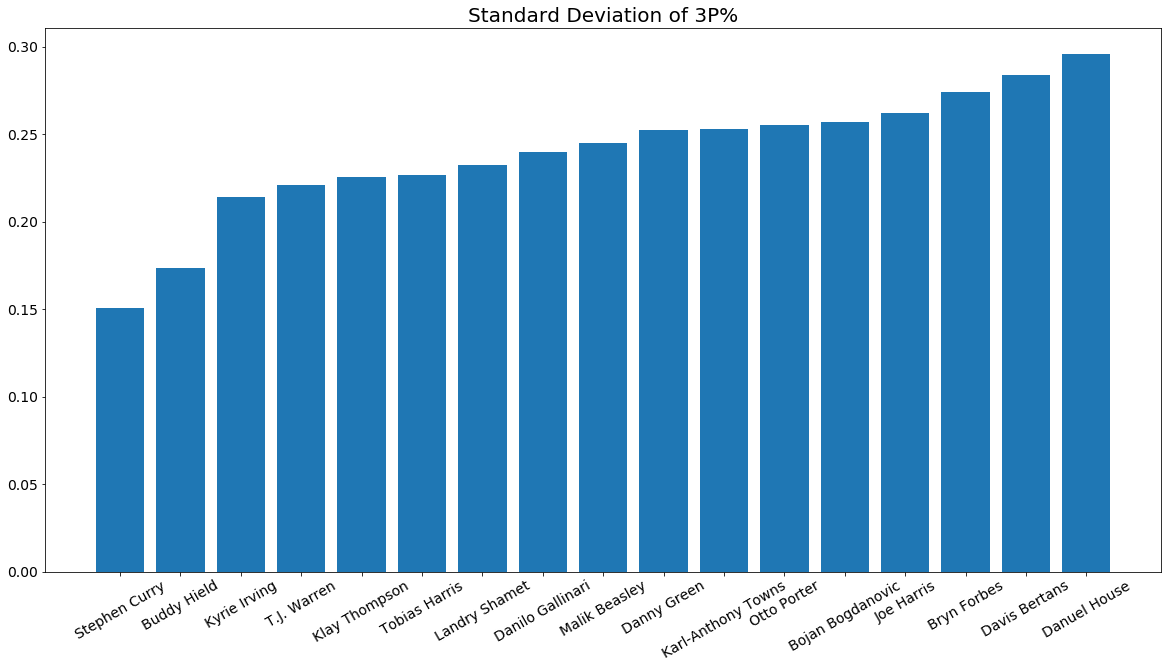

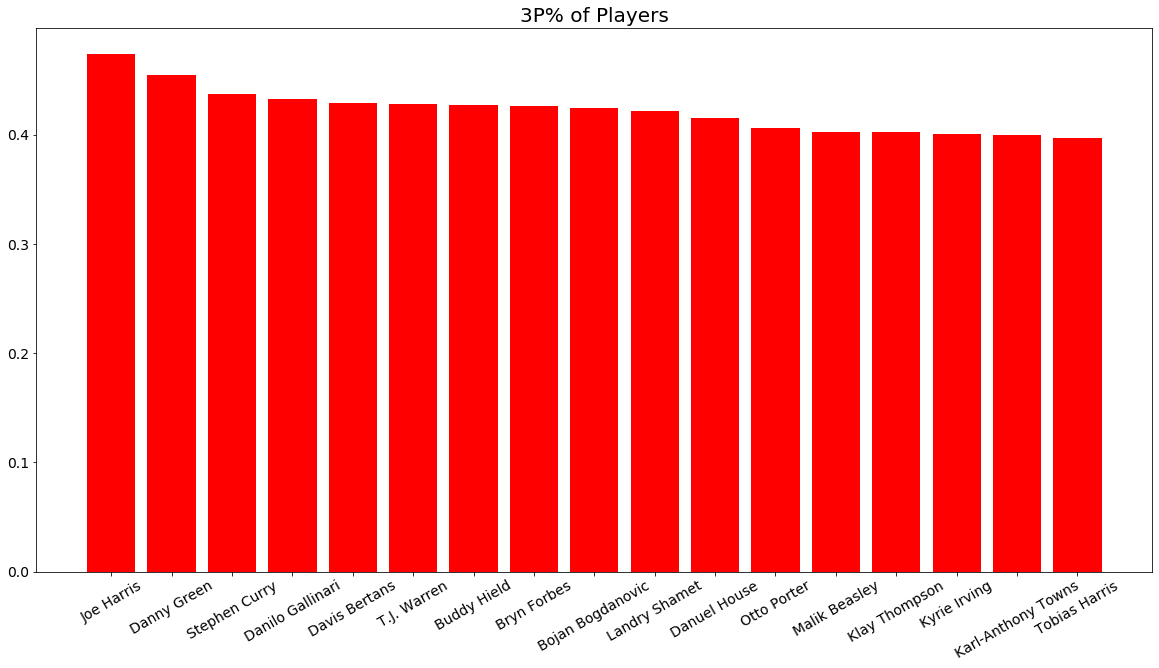

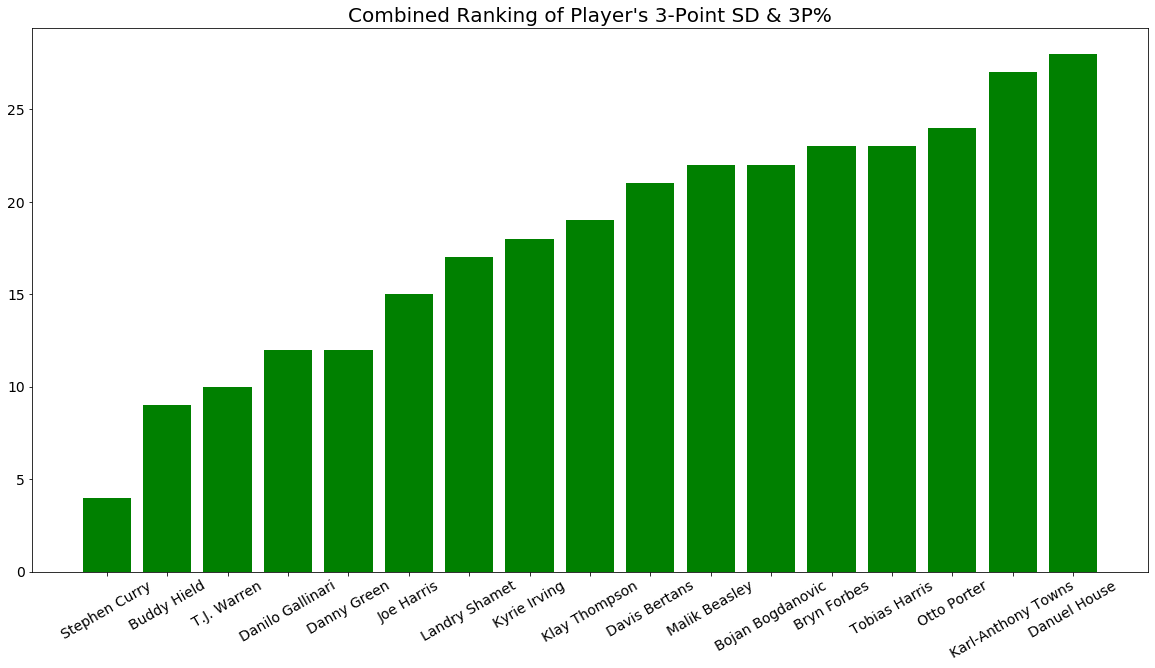

In [7]:
plot_list = ['Standard Deviation', '3P%', 'Score']

for item in plot_list:
    
    fig = plt.figure(figsize=(20,10))
    if item == 'Standard Deviation':
        plt.bar(df.sort_values(by=item, ascending=True)['Player Name'], df.sort_values(by=item, ascending=True)[item])
        plt.xticks(fontsize=14, rotation=30)
        plt.yticks(fontsize=14)
        plt.title('Standard Deviation of 3P%', fontsize=20)
        plt.show()
    
    elif item == 'Score':
        plt.bar(df.sort_values(by=item, ascending=True)['Player Name'], df.sort_values(by=item, ascending=True)[item], color='green')
        plt.xticks(fontsize=14, rotation=30)
        plt.yticks(fontsize=14)
        plt.title("Combined Ranking of Player's 3-Point SD & 3P%", fontsize=20)
        plt.show()
    
    else:
        plt.bar(df.sort_values(by=item, ascending=False)['Player Name'], df.sort_values(by=item, ascending=False)[item], color='red')
        plt.xticks(fontsize=14, rotation=30)
        plt.yticks(fontsize=14)
        plt.title('3P% of Players', fontsize=20)
        plt.show()

In [93]:
def distribution_plot(dict):
    for key, value in dict.items():
        plt.figure(figsize=(7,5))
        plt.hist(x='3P%', data=gamelog[gamelog['ID'] == key], color='tomato', bins=15)
        plt.title(dict[key] + ' - 3P% Distribution Across Season')
        plt.show()   

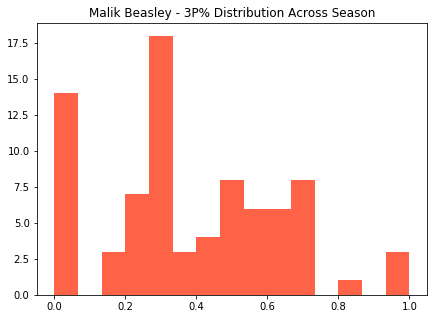

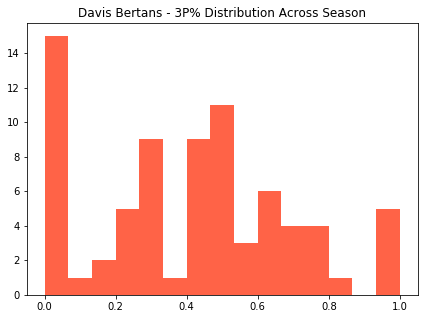

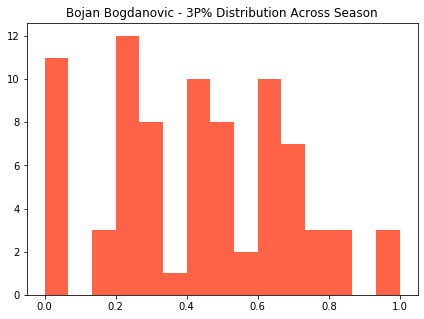

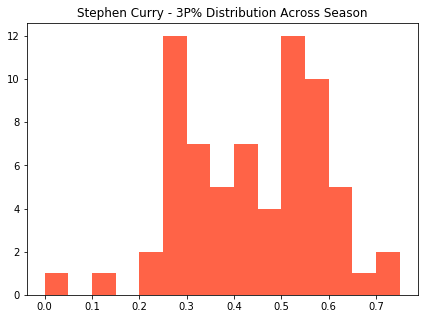

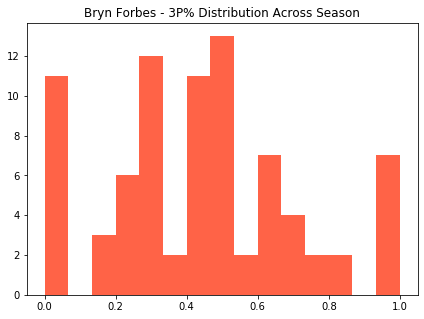

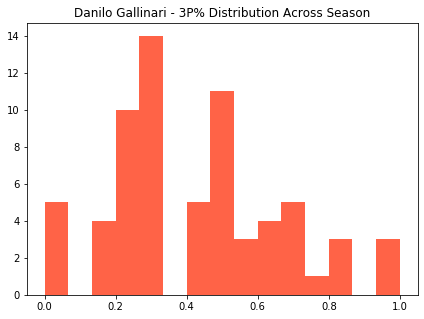

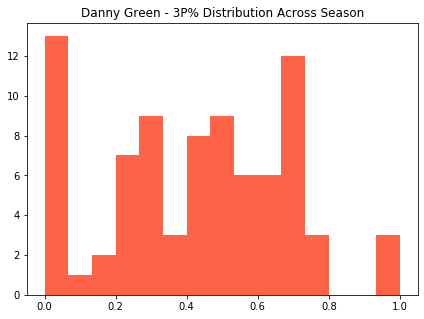

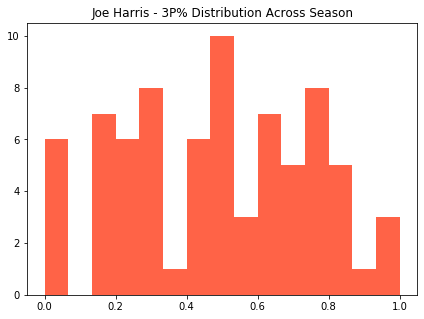

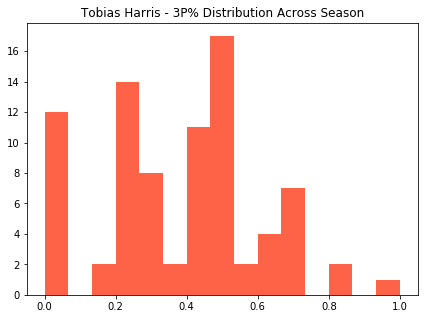

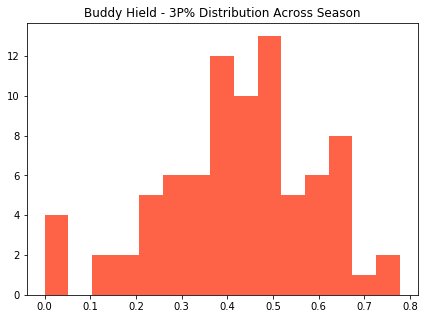

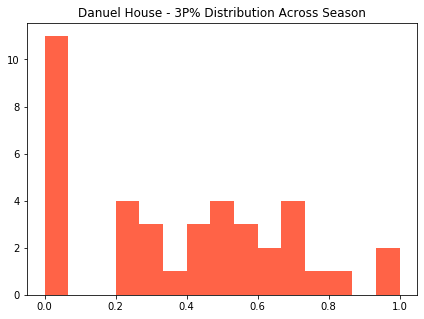

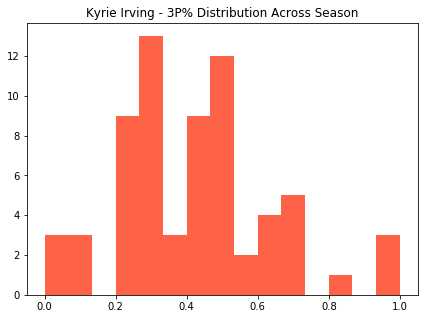

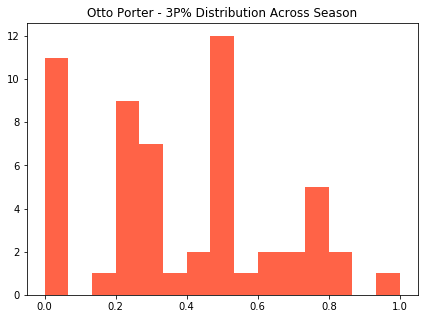

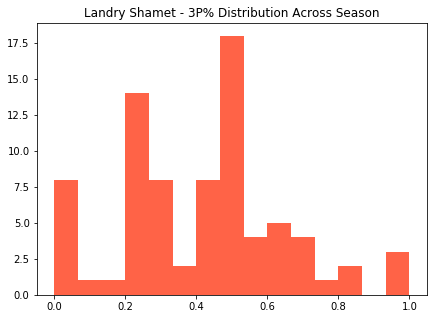

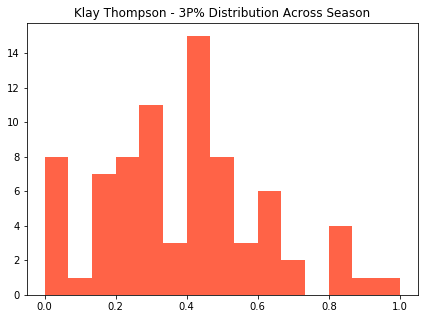

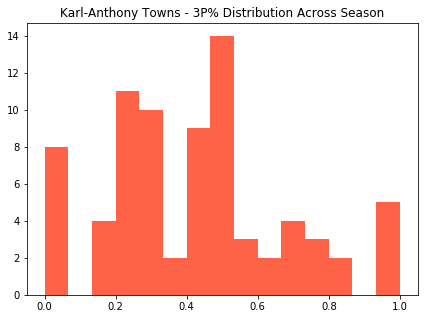

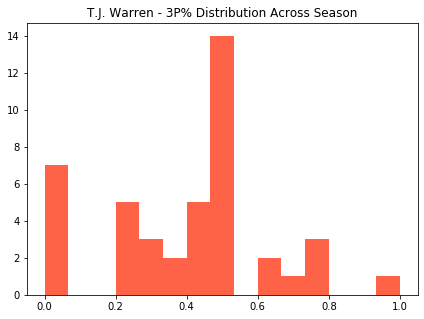

In [94]:
distribution_plot(elite_dict)